# Scraping Jumia Ecommerce Site: DSE HACKATHON

## Import libraries

In [768]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import time

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import os
import csv

## Define function to fetch website html data

In [769]:
def fetch_html_data(web_address):
    try:
        # print(f"\nFetching data from {web_address}...")
        res = req.get(web_address)
        return res
    except req.exceptions.RequestException as e:
        print('Stopped:', e)
    except TypeError as e:
        print('Stopped:', e)

# Define function to convert html data to BeautifulSoup object 

In [770]:
def convert_web_data_to_beautiful_soup_obj(web_data):
    try:
        # print("Creating BeautifulSoup object...")
        soup_obj = BeautifulSoup(web_data.text, "html.parser")
        # print("Success! Object created!")
        return soup_obj
    except Exception as e:
        print("Stopped:", e)

### Create array of products on each page, add each to product dictionary & append to array iteratively

In [771]:
all_products_list = []

def append_one_product_details_dictionary_to_list(pg):
    # print(f"Appending page {pg} products' details to array")
    
    page_products_details_soup = soup.find_all("article", class_="prd _fb col c-prd")
    
    for detail in page_products_details_soup:
        details_dict = {"name": detail.find("h3", class_="name").text.strip(),
                        "new_price": detail.find("div", class_="prc").text.strip(),
                        "old_price": detail.find("div", class_="old").text.strip() if detail.find("div", class_="old") else None,
                        "discount": detail.find("div", class_="bdg _dsct _sm").text.strip() if detail.find("div", class_="bdg _dsct _sm") else None,
                        "rating": detail.find("div", class_="stars _s").text.strip() if detail.find("div", class_="stars _s") else None,
                        "votes": detail.find("div", class_="rev").text.strip() if detail.find("div", class_="rev") else None}
        all_products_list.append(details_dict)


# len(product_details_clean)

### Declare the products' url & the total webpage count

In [772]:
other_pages_url = "https://www.jumia.co.ke/all-products/?page="
webpage_num_total = 50

### Fetch webdata, convert to BeautifulSoup Object, add product details dictionary to list

In [773]:
# If scraped products csv doesn't exist, run the scraper function below & save products to csv ELSE continue & read csv
if not os.path.exists('all_products_list.csv'):
    for page in range(1, webpage_num_total+1, 1):
        other_pages_url = "https://www.jumia.co.ke/all-products/?page="
        page = str(page)
        other_pages_url = other_pages_url + page
        response = fetch_html_data(other_pages_url)
        # time.sleep(2.5)
        soup = convert_web_data_to_beautiful_soup_obj(response)
        append_one_product_details_dictionary_to_list(page)
    
    # Convert scraped list to dataframe
    df = pd.DataFrame(all_products_list)
    # Save scraped dataframe to csv to prevent scraping each time I run the notebook
    df.to_csv('all_products_list.csv')

### Check product count

In [774]:
all_products_list = pd.read_csv('all_products_list.csv')  # Read products list from csv
len(all_products_list)

2000

### Convert products list to pandas dataframe

In [775]:
products_df = pd.DataFrame(all_products_list)
products_df.head()

,Unnamed: 0,name,new_price,old_price,discount,rating,votes
0,0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,KSh 899,"KSh 1,560",42%,4.5 out of 5,4.5 out of 5(2217)
1,1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,KSh 854,"KSh 1,460",42%,4.7 out of 5,4.7 out of 5(612)
2,2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,"KSh 1,174","KSh 1,302",10%,4.7 out of 5,4.7 out of 5(1119)
3,3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",KSh 728,"KSh 1,040",30%,4.6 out of 5,4.6 out of 5(830)
4,4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,KSh 655,"KSh 1,040",37%,4.6 out of 5,4.6 out of 5(621)


In [776]:
products_df.shape

(2000, 7)

# Data Cleaning Section

### Clean new_price column

In [777]:
# Remove currency name 'Ksh' & convert values to float
def remove_currency_name_in_new_price(val):
    val = val.split(' ')[1]
    return val
products_df['new_price'] = products_df['new_price'].apply(remove_currency_name_in_new_price)

In [778]:
print(type(products_df['new_price'][1]))
print(products_df['new_price'].head())

<class 'str'>
0      899
1      854
2    1,174
3      728
4      655
Name: new_price, dtype: object


In [779]:
# Remove comma from thousands price values
products_df['new_price'] = products_df['new_price'].apply(lambda x: x.replace(',','') if ',' in x else x)
products_df['new_price'].head()

0     899
1     854
2    1174
3     728
4     655
Name: new_price, dtype: object

In [780]:
print(type(products_df['new_price'][1]))

<class 'str'>


In [781]:
# Convert new_price column to float
products_df['new_price'] = products_df['new_price'].apply(lambda x: float(x))

In [782]:
print(type(products_df['new_price'][1]))

<class 'numpy.float64'>


In [783]:
products_df.head()

,Unnamed: 0,name,new_price,old_price,discount,rating,votes
0,0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,"KSh 1,560",42%,4.5 out of 5,4.5 out of 5(2217)
1,1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,"KSh 1,460",42%,4.7 out of 5,4.7 out of 5(612)
2,2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,"KSh 1,302",10%,4.7 out of 5,4.7 out of 5(1119)
3,3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,"KSh 1,040",30%,4.6 out of 5,4.6 out of 5(830)
4,4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,"KSh 1,040",37%,4.6 out of 5,4.6 out of 5(621)


### Clean old_price column

In [784]:
# Use [:10] notation to print the first 10 values
products_df['old_price'].unique()[:10]

array(['KSh 1,560', 'KSh 1,460', 'KSh 1,302', 'KSh 1,040', 'KSh 5,610',
       'KSh 780', 'KSh 39,999', 'KSh 3,840', 'KSh 1,099', 'KSh 15,995'],
      dtype=object)

In [785]:
# Remove currency name 'Ksh'
# type(products_df['old_price'][1])
products_df['old_price'] = products_df['old_price'].apply(lambda x: x.split(' ')[1] if x is not None and isinstance(x,str) else x)
products_df['old_price'].head()

0    1,560
1    1,460
2    1,302
3    1,040
4    1,040
Name: old_price, dtype: object

In [786]:
# Remove commas from values
products_df['old_price'] = products_df['old_price'].apply(lambda x: x.replace(',','') if x is not None and isinstance(x,str) else x)
products_df['old_price'].head(10)

0     1560
1     1460
2     1302
3     1040
4     1040
5     1040
6     5610
7      780
8    39999
9     3840
Name: old_price, dtype: object

In [787]:
# Convert the string values into floats
products_df['old_price'] = products_df['old_price'].apply(lambda x: float(x) if x is not None else x)
products_df['old_price'].head(10)

0     1560.0
1     1460.0
2     1302.0
3     1040.0
4     1040.0
5     1040.0
6     5610.0
7      780.0
8    39999.0
9     3840.0
Name: old_price, dtype: float64

In [788]:
products_df['old_price']

0       1560.0
1       1460.0
2       1302.0
3       1040.0
4       1040.0
         ...  
1995    1788.0
1996    1000.0
1997    1000.0
1998    1500.0
1999    2712.0
Name: old_price, Length: 2000, dtype: float64

In [789]:
# Index 18 from above was null. So checking its type: 
type(products_df['old_price'][18])

numpy.float64

In [790]:
products_df.head(20)

,Unnamed: 0,name,new_price,old_price,discount,rating,votes
0,0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,42%,4.5 out of 5,4.5 out of 5(2217)
1,1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,42%,4.7 out of 5,4.7 out of 5(612)
2,2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,10%,4.7 out of 5,4.7 out of 5(1119)
3,3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,30%,4.6 out of 5,4.6 out of 5(830)
4,4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,37%,4.6 out of 5,4.6 out of 5(621)
5,5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,30%,4.7 out of 5,4.7 out of 5(219)
6,6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,35%,4.4 out of 5,4.4 out of 5(352)
7,7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,25%,4.4 out of 5,4.4 out of 5(560)
8,8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,17%,4.6 out of 5,4.6 out of 5(44)
9,9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,42%,4.6 out of 5,4.6 out of 5(416)


### Cleaning 'discount' column

In [791]:
# Check unique values if any
products_df['discount'].unique()[:10]

array(['42%', '10%', '30%', '37%', '35%', '25%', '17%', '27%', '18%',
       '14%'], dtype=object)

In [792]:
# Remove the percent sign
products_df['discount'] = products_df['discount'].apply(lambda x: x.replace('%','') if x is not None and isinstance(x,str) else x)
products_df['discount'].unique()

array(['42', '10', '30', '37', '35', '25', '17', '27', '18', '14', '4',
       '31', '43', '8', '11', '20', '9', '12', '34', '33', '29', '13',
       '28', nan, '24', '5', '3', '32', '15', '48', '23', '38', '36',
       '49', '46', '41', '16', '40', '39', '44', '50', '79', '6', '7',
       '47', '21', '45', '22', '19', '26', '57', '1', '53', '51', '58',
       '56', '54', '64', '59', '2', '55'], dtype=object)

In [793]:
# Convert values into float & divide by 100 to represent the percentages as decimal values
products_df['discount'] = products_df['discount'].apply(lambda x: float(x)/100 if x is not None else x)
products_df['discount'].unique()  # A numbers now floats and None replaced with NaN

array([0.42, 0.1 , 0.3 , 0.37, 0.35, 0.25, 0.17, 0.27, 0.18, 0.14, 0.04,
       0.31, 0.43, 0.08, 0.11, 0.2 , 0.09, 0.12, 0.34, 0.33, 0.29, 0.13,
       0.28,  nan, 0.24, 0.05, 0.03, 0.32, 0.15, 0.48, 0.23, 0.38, 0.36,
       0.49, 0.46, 0.41, 0.16, 0.4 , 0.39, 0.44, 0.5 , 0.79, 0.06, 0.07,
       0.47, 0.21, 0.45, 0.22, 0.19, 0.26, 0.57, 0.01, 0.53, 0.51, 0.58,
       0.56, 0.54, 0.64, 0.59, 0.02, 0.55])

In [794]:
# Check head once more
products_df.head()

,Unnamed: 0,name,new_price,old_price,discount,rating,votes
0,0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5 out of 5,4.5 out of 5(2217)
1,1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7 out of 5,4.7 out of 5(612)
2,2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7 out of 5,4.7 out of 5(1119)
3,3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6 out of 5,4.6 out of 5(830)
4,4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6 out of 5,4.6 out of 5(621)


### Cleaning the rating column

In [795]:
# Check for unique values first
products_df['rating'].unique()

array(['4.5 out of 5', '4.7 out of 5', '4.6 out of 5', '4.4 out of 5',
       '4.3 out of 5', '4 out of 5', '3.3 out of 5', '4.2 out of 5',
       '4.1 out of 5', '4.9 out of 5', '5 out of 5', '3.6 out of 5',
       '3.7 out of 5', nan, '3.9 out of 5', '3.8 out of 5',
       '3.4 out of 5', '4.8 out of 5', '3.5 out of 5', '3 out of 5',
       '1.7 out of 5', '3.1 out of 5', '3.2 out of 5', '2.3 out of 5',
       '1 out of 5', '2 out of 5', '2.5 out of 5', '2.8 out of 5',
       '2.7 out of 5', '1.5 out of 5', '1.8 out of 5'], dtype=object)

In [796]:
# Split rating string values into 4 elements and select the first element unless its None(left as is)
products_df['rating'] = products_df['rating'].apply(lambda x: x.split(' ')[0] if x is not None and isinstance(x,str) else x)
products_df['rating'].unique()

array(['4.5', '4.7', '4.6', '4.4', '4.3', '4', '3.3', '4.2', '4.1', '4.9',
       '5', '3.6', '3.7', nan, '3.9', '3.8', '3.4', '4.8', '3.5', '3',
       '1.7', '3.1', '3.2', '2.3', '1', '2', '2.5', '2.8', '2.7', '1.5',
       '1.8'], dtype=object)

In [797]:
# Convert the values into float
products_df['rating'] = products_df['rating'].apply(lambda x: float(x) if x is not None else x)
type(products_df['rating'][1])

numpy.float64

In [798]:
products_df.head(20)

,Unnamed: 0,name,new_price,old_price,discount,rating,votes
0,0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,4.5 out of 5(2217)
1,1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,4.7 out of 5(612)
2,2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,4.7 out of 5(1119)
3,3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,4.6 out of 5(830)
4,4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,4.6 out of 5(621)
5,5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,4.7 out of 5(219)
6,6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,0.35,4.4,4.4 out of 5(352)
7,7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,0.25,4.4,4.4 out of 5(560)
8,8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,0.17,4.6,4.6 out of 5(44)
9,9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,4.6 out of 5(416)


### Cleaning the 'votes' column

In [799]:
# Explore unique values
products_df['votes'].unique()[:10]

array(['4.5 out of 5(2217)', '4.7 out of 5(612)', '4.7 out of 5(1119)',
       '4.6 out of 5(830)', '4.6 out of 5(621)', '4.7 out of 5(219)',
       '4.4 out of 5(352)', '4.4 out of 5(560)', '4.6 out of 5(44)',
       '4.6 out of 5(416)'], dtype=object)

In [800]:
# Extract the votes count with string manipulation methods & convert values to integer values
products_df['votes'] = products_df['votes'].apply(lambda x: float(x.split('(')[1].split(')')[0]) if x is not None and isinstance(x,str) else x)
products_df['votes'].unique()

array([2.217e+03, 6.120e+02, 1.119e+03, 8.300e+02, 6.210e+02, 2.190e+02,
       3.520e+02, 5.600e+02, 4.400e+01, 4.160e+02, 6.400e+01, 3.610e+02,
       7.200e+01, 6.700e+01, 2.500e+01, 1.600e+01, 4.100e+01, 2.600e+01,
       1.500e+01, 8.000e+00, 9.000e+00, 2.700e+01, 2.000e+00, 5.000e+00,
       1.000e+00, 6.000e+00,       nan, 1.000e+01, 3.000e+00, 1.100e+01,
       4.410e+02, 1.386e+03, 1.429e+03, 2.420e+02, 9.670e+02, 7.220e+02,
       1.622e+03, 3.070e+02, 3.745e+03, 6.010e+02, 2.720e+03, 4.750e+02,
       2.013e+03, 8.920e+02, 2.218e+03, 1.527e+03, 6.750e+02, 2.080e+02,
       6.330e+02, 3.820e+02, 7.600e+01, 9.810e+02, 4.470e+02, 1.260e+02,
       1.067e+03, 1.330e+02, 2.170e+02, 4.710e+03, 1.217e+03, 2.280e+02,
       4.460e+02, 5.000e+01, 4.440e+02, 1.010e+02, 9.000e+01, 4.590e+02,
       1.105e+03, 1.428e+03, 2.180e+02, 7.100e+01, 1.495e+03, 3.540e+02,
       3.980e+02, 1.120e+03, 1.888e+03, 8.900e+01, 6.570e+02, 5.900e+01,
       2.770e+02, 1.503e+03, 2.830e+02, 3.220e+02, 

In [801]:
products_df.head(20)

,Unnamed: 0,name,new_price,old_price,discount,rating,votes
0,0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2217.0
1,1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,621.0
5,5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,219.0
6,6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,0.35,4.4,352.0
7,7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,0.25,4.4,560.0
8,8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,0.17,4.6,44.0
9,9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,416.0


## Dealing with null values

In [802]:
products_df.isnull().sum().idxmax()

'old_price'

In [803]:
print(f"new_price nulls: {products_df.new_price.isnull().sum()}")
print(f"old_price nulls: {products_df.old_price.isnull().sum()}")
print(f"discount nulls: {products_df.discount.isnull().sum()}")
print(f"rating nulls: {products_df.rating.isnull().sum()}")
print(f"votes nulls: {products_df.votes.isnull().sum()}")

new_price nulls: 0
old_price nulls: 301
discount nulls: 301
rating nulls: 218
votes nulls: 218


### Fill null values in discount column 

In [804]:
# Use discount column average to fill nulls
products_df['discount'] = products_df['discount'].fillna(round(products_df['discount'].mean(), 2))
products_df.discount.isnull().sum()

0

### Fill null values in old_price based on the discount column average

In [805]:
def multiply_fill_old_price_column_nulls(row):
    new_price = row['new_price']
    discount_column_mean = round(products_df['discount'].mean(), 2)
    discount_multiplier = 1 - discount_column_mean
    
    if not pd.isna(row['old_price']):
        return row['old_price']
    return new_price * discount_column_mean
        
products_df['old_price'] = products_df.apply(multiply_fill_old_price_column_nulls, axis=1)
products_df.old_price.isnull().sum()

0

### Fill rating nulls with column mean

In [806]:
products_df['rating'] = products_df['rating'].fillna(round(products_df['rating'].mean(), 2))
products_df.rating.isnull().sum()
# type(products_df['rating'][1])

0

### Fill votes nulls with column mean

In [807]:
products_df['votes'] = products_df['votes'].fillna(round(products_df['votes'].mean(), 2))
products_df.votes.isnull().sum()

0

## Rechecking nulls for all columns again

In [808]:
print(f"new_price nulls: {products_df.new_price.isnull().sum()}")
print(f"old_price nulls: {products_df.old_price.isnull().sum()}")
print(f"discount nulls: {products_df.discount.isnull().sum()}")
print(f"rating nulls: {products_df.rating.isnull().sum()}")
print(f"votes nulls: {products_df.votes.isnull().sum()}")

new_price nulls: 0
old_price nulls: 0
discount nulls: 0
rating nulls: 0
votes nulls: 0


In [809]:
products_df.head(10)

,Unnamed: 0,name,new_price,old_price,discount,rating,votes
0,0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2217.0
1,1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,621.0
5,5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,219.0
6,6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,0.35,4.4,352.0
7,7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,0.25,4.4,560.0
8,8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,0.17,4.6,44.0
9,9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,416.0


In [810]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2000 non-null   int64  
 1   name        2000 non-null   object 
 2   new_price   2000 non-null   float64
 3   old_price   2000 non-null   float64
 4   discount    2000 non-null   float64
 5   rating      2000 non-null   float64
 6   votes       2000 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 109.5+ KB


### Assign cleaned dataframe to a new name

In [811]:
products_clean_df = products_df
products_clean_df

,Unnamed: 0,name,new_price,old_price,discount,rating,votes
0,0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.50,2217.00
1,1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.70,612.00
2,2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.70,1119.00
3,3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.60,830.00
4,4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.60,621.00
...,...,...,...,...,...,...,...
1995,1995,Plating Magsafe Case For IPhone 11 Wireless Ch...,959.0,1788.0,0.46,4.12,76.29
1996,1996,Ors Olive Oil Edge Control Hair Gel-Stronger H...,640.0,1000.0,0.36,4.12,76.29
1997,1997,HP 32GB High Speed Flash Disk + Free 32 GB Mem...,999.0,1000.0,0.01,4.12,76.29
1998,1998,Cat6 Lan Network Ethernet Cable 30M Gray,950.0,1500.0,0.37,4.00,7.00


# DATA VISUALIZATION SECTION

### Summary stats of the data

In [812]:
summary_stats = products_clean_df.describe()
summary_stats

,Unnamed: 0,new_price,old_price,discount,rating,votes
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,3146.599000,3880.282380,0.317235,4.124180,76.287110
std,577.494589,7312.399082,8741.765815,0.127373,0.660755,246.965393
min,0.000000,53.000000,25.600000,0.010000,1.000000,1.000000
25%,499.750000,599.000000,700.000000,0.250000,3.900000,4.000000
50%,999.500000,1024.500000,1426.500000,0.320000,4.120000,16.000000
75%,1499.250000,2276.250000,2806.750000,0.420000,4.500000,76.290000
max,1999.000000,106499.000000,99999.000000,0.790000,5.000000,4710.000000


### Deriving the correlation matrix

In [813]:
# Returning correlation matrix for only the numerical columns
correlation_matrix = products_clean_df.corr(method='pearson', numeric_only=True)
# correlation_matrix.to_csv("pearson_correlation.csv")
correlation_matrix

,Unnamed: 0,new_price,old_price,discount,rating,votes
Unnamed: 0,1.000000,-0.072074,-0.067131,0.015967,-0.017802,-0.256594
new_price,-0.072074,1.000000,0.933073,-0.191640,0.041622,-0.037710
old_price,-0.067131,0.933073,1.000000,-0.136041,0.034496,-0.043055
discount,0.015967,-0.191640,-0.136041,1.000000,-0.123632,-0.038871
rating,-0.017802,0.041622,0.034496,-0.123632,1.000000,0.028958
votes,-0.256594,-0.037710,-0.043055,-0.038871,0.028958,1.000000


Text(0.5, 1.0, 'Correlation Matrix of the Numeric Columns')

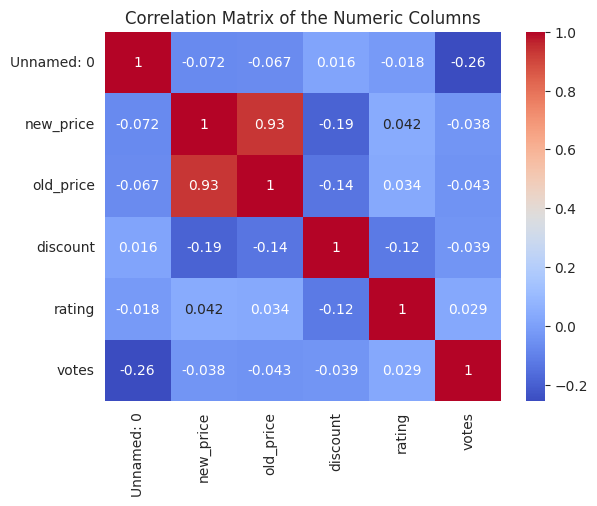

In [814]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of the Numeric Columns')

### Visualize top-rated products with at least 200 votes

In [815]:
# First filter for products with at least 200 votes (More votes makes a product rating more reliable)
products_with_atleast_200_votes_df = products_clean_df[products_clean_df['votes'] >= 200]
products_with_atleast_200_votes_df

,Unnamed: 0,name,new_price,old_price,discount,rating,votes
0,0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2217.0
1,1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,621.0
...,...,...,...,...,...,...,...
1421,1421,Fashion Sexiest Mock Neck Ribbed Bodycon Dress...,597.0,639.0,0.07,3.9,536.0
1425,1425,Fashion 4 In 1 Ladies Handbags Women Shoulder ...,969.0,1358.0,0.29,3.4,221.0
1463,1463,Dr. Rashel Brightening & Anti-Aging Face Cream...,495.0,1000.0,0.51,4.1,219.0
1756,1756,Toilex Poa Toilet Paper White 10 Pack Unwrapped,245.0,78.4,0.32,3.8,877.0


In [816]:
# Check counts of products with rating at least 4.5
top_rated_products_df = products_with_atleast_200_votes_df[products_with_atleast_200_votes_df['rating'] >= 4.5]
top_rated_products_df

,Unnamed: 0,name,new_price,old_price,discount,rating,votes
0,0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2217.0
1,1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,621.0
5,5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,219.0
9,9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,416.0
47,47,Garnier Vitamin C Booster Serum 30ml Twin Pack,2625.0,3500.0,0.25,4.6,441.0
50,50,Jameson Jameson Irish Whiskey - 1 Litre,2599.0,3827.0,0.32,4.6,242.0
58,58,Jikokoa Xtra - Black,2999.0,4000.0,0.25,4.5,475.0


In [817]:
# Selecting only votes & rating column before plotting
new_top_rated_products_df = top_rated_products_df[['name','rating', 'votes']].reset_index(drop=True)
new_top_rated_products_df

,name,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,4.5,2217.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,4.6,621.0
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,4.7,219.0
6,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,4.6,416.0
7,Garnier Vitamin C Booster Serum 30ml Twin Pack,4.6,441.0
8,Jameson Jameson Irish Whiskey - 1 Litre,4.6,242.0
9,Jikokoa Xtra - Black,4.5,475.0


Text(0.5, 0, 'Rating')

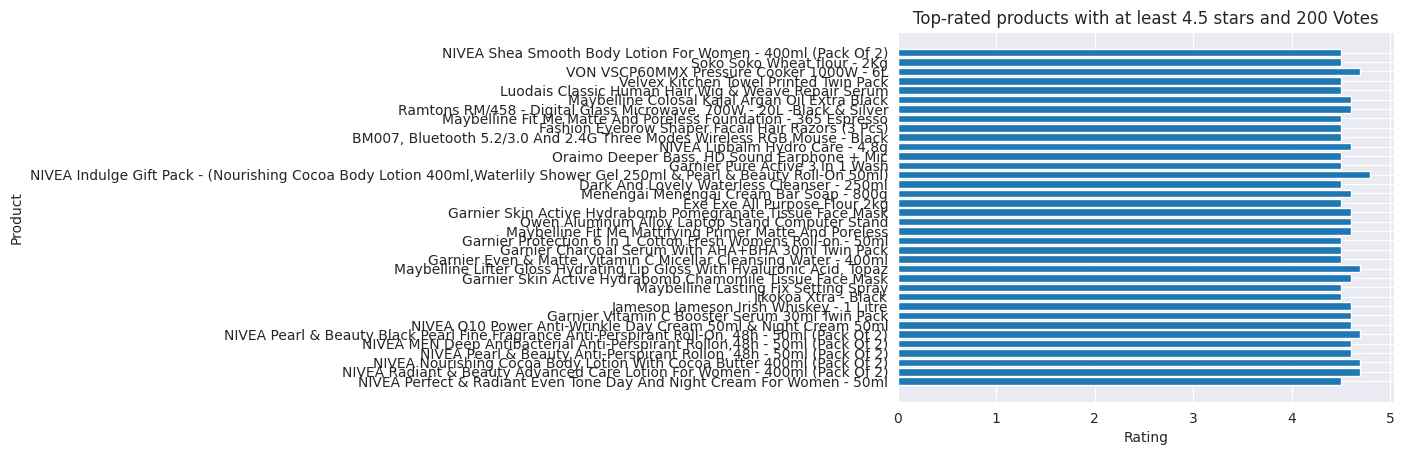

In [818]:
# Creating a horizontal bar plot
plt.barh(new_top_rated_products_df['name'], new_top_rated_products_df['rating'])

plt.title("Top-rated products with at least 4.5 stars and 200 Votes")
plt.ylabel("Product")
plt.xlabel("Rating")

### Showing product price distribution: Histogram with Kernel density estimate (kde) curve

Text(0.5, 1.0, 'Distribution of Product Prices')

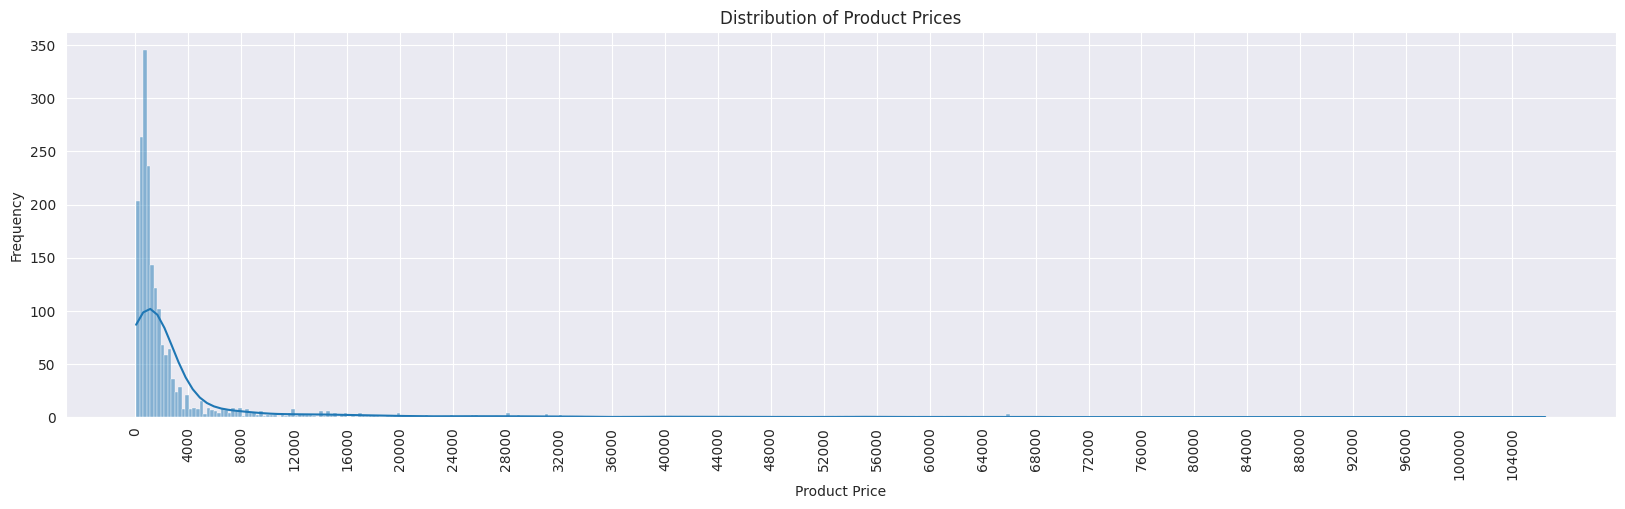

In [819]:
plt.figure(figsize=(20, 5))
sns.histplot(products_clean_df['new_price'], kde=True)
plt.xlabel('Product Price')
plt.xticks(np.arange(0, max(products_clean_df['new_price'])+1, 4000),rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices')

### Visualizing discount distribution

Text(0.5, 1.0, 'Distribution of Discounts')

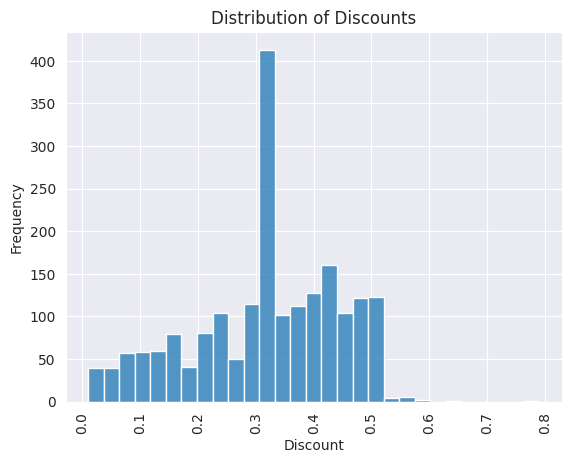

In [820]:
sns.histplot(products_clean_df['discount'])
plt.xlabel('Discount')
# plt.xticks(np.arange(0,max(products_clean_df['discount'])+1,0.5),rotation=90)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Discounts')

### Visualizing rating distribution

(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350')])

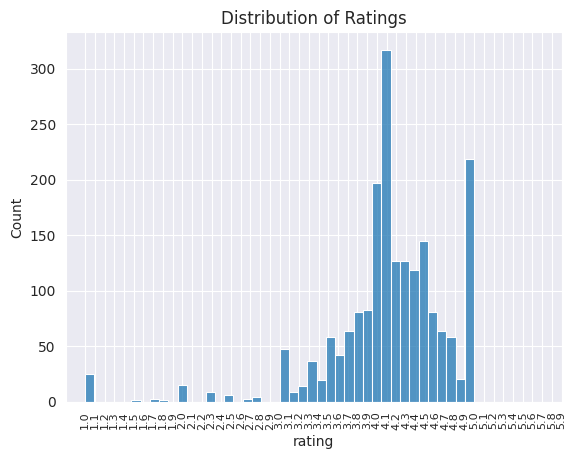

In [821]:
sns.histplot(data=products_clean_df, x='rating')
plt.title('Distribution of Ratings')
plt.xticks(np.arange(1.0, max(products_clean_df['rating'])+1, 0.1),rotation=90,fontsize=8)
plt.yticks()

### Visualizing relationship between rating and votes

Text(0.5, 1.0, 'Scatterplot relationship between Votes and Rating')

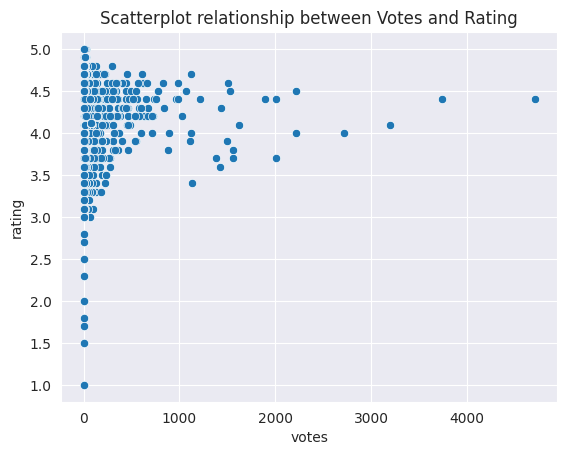

In [822]:
sns.scatterplot(data=products_clean_df, x='votes', y='rating')
plt.title('Scatterplot relationship between Votes and Rating')

### Product Name Analysis

In [823]:
words = ' '.join(products_clean_df['name']).split()
all_words = Counter(words)
# len(all_words)  # 4580

# Returning an array of tuples with all_words & their counts, then return first 10
all_words_counts = all_words.most_common()
all_words_counts[:10]

[('Fashion', 493),
 ('-', 351),
 ('+', 168),
 ('Shoes', 156),
 ('&', 144),
 ('Black', 141),
 ('For', 134),
 ('With', 131),
 ("Men's", 109),
 ('Hair', 100)]

In [824]:
# Return only the alphabetical elements & their counts, & return the first 10
only_alpha_words_list = [(word, count) for word, count in all_words_counts if word.isalpha()]
only_alpha_words_list[:10]

[('Fashion', 493),
 ('Shoes', 156),
 ('Black', 141),
 ('For', 134),
 ('With', 131),
 ('Hair', 100),
 ('And', 96),
 ('Men', 70),
 ('Women', 69),
 ('Casual', 69)]

In [825]:
# Select the top 30 words
first_30_words = only_alpha_words_list[:31]
first_30_words

# Future: Use library to remove conjuctions such as 'and' from this list

[('Fashion', 493),
 ('Shoes', 156),
 ('Black', 141),
 ('For', 134),
 ('With', 131),
 ('Hair', 100),
 ('And', 96),
 ('Men', 70),
 ('Women', 69),
 ('Casual', 69),
 ('Smart', 68),
 ('White', 68),
 ('Set', 66),
 ('Wireless', 65),
 ('TV', 64),
 ('Bluetooth', 64),
 ('Electric', 64),
 ('Light', 63),
 ('Leather', 58),
 ('In', 57),
 ('Mens', 57),
 ('Power', 54),
 ('Cable', 53),
 ('Bag', 53),
 ('Free', 52),
 ('Cotton', 51),
 ('Ladies', 51),
 ('Watch', 50),
 ('Blue', 49),
 ('LED', 45),
 ('Bags', 45)]

Text(0.5, 1.0, 'Bar chart of Product Names & Values')

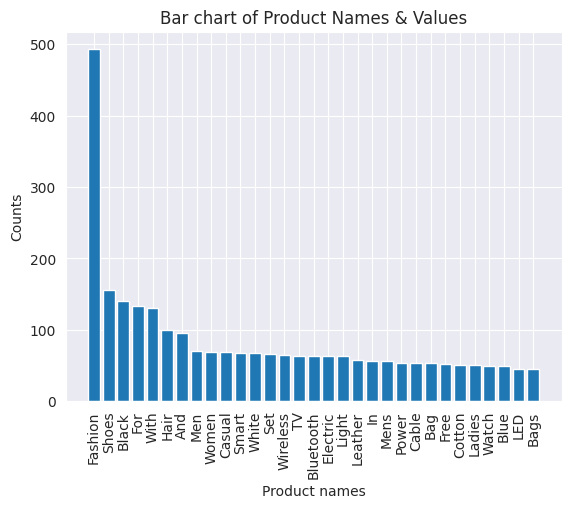

In [826]:
# Plot a chart with the first 30 words
plt.bar([d[0] for d in first_30_words], [d[1] for d in first_30_words])
plt.xlabel("Product names")
plt.xticks(rotation=90)
plt.ylabel("Counts")
plt.title("Bar chart of Product Names & Values")

### Creating pairplot showing relationship between various numerical columns

Text(0.5, 1.02, 'Pair Plot of Numerical Features')

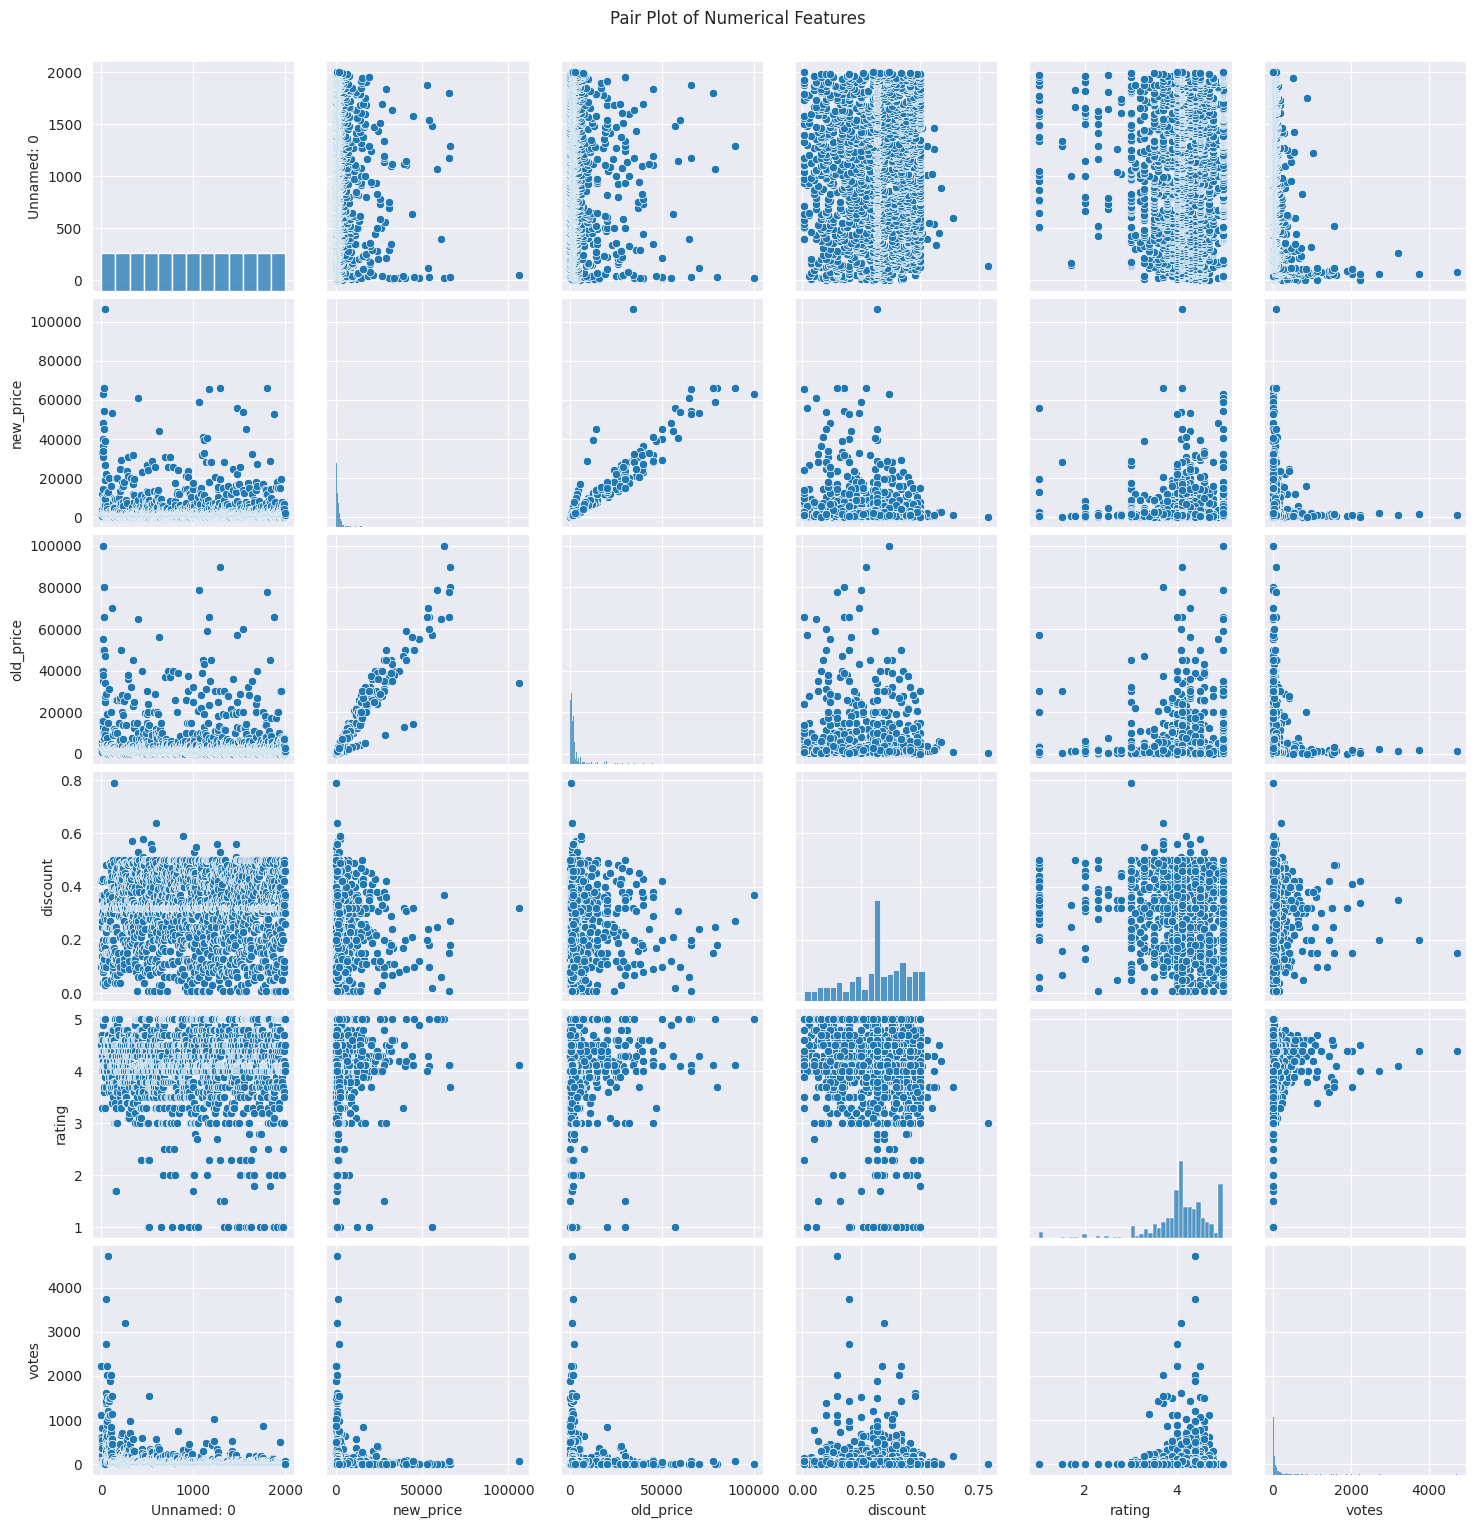

In [827]:
sns.pairplot(products_clean_df)
plt.suptitle('Pair Plot of Numerical Features', y=1.02)